# Cosmic-ray composition spectrum analysis
### Table of contents
1. [Data preprocessing](#Data-preprocessing)
2. [Fitting random forest](#Fit-random-forest-and-run-10-fold-CV-validation)
3. [Fraction correctly identified](#Fraction-correctly-identified)
4. [Spectrum](#Spectrum)
5. [Unfolding](#)
6. [Feature importance](#Feature-importance)

In [5]:
import sys
sys.path.append('/home/jbourbeau/cr-composition')
print('Added to PYTHONPATH')

Added to PYTHONPATH


In [6]:
from __future__ import division, print_function
import argparse
from collections import defaultdict
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn.apionly as sns

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, KFold

import composition as comp
import composition.analysis.plotting as plotting

# Plotting-related
sns.set_palette('muted')
sns.set_color_codes()
color_dict = defaultdict()
for i, composition in enumerate(['light', 'heavy', 'total']):
    color_dict[composition] = sns.color_palette('muted').as_hex()[i]
%matplotlib inline

## Data preprocessing
1. Load simulation/data dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets

### Simulation

In [7]:
df_sim, cut_dict_sim = comp.load_dataframe(type_='sim', config='IT73', return_cut_dict=True)
selection_mask = np.array([True] * len(df_sim))
standard_cut_keys = ['lap_reco_success', 'lap_zenith', 'num_hits_1_30', 'IT_signal',
                     'max_qfrac_1_30', 'lap_containment', 'energy_range_lap']
for key in standard_cut_keys:
    selection_mask *= cut_dict_sim[key]

df_sim = df_sim[selection_mask]

feature_list, feature_labels = comp.get_training_features()
print('training features = {}'.format(feature_list))
X_train_sim, X_test_sim, y_train_sim, y_test_sim, le = comp.get_train_test_sets(
    df_sim, feature_list, comp_class=True)

print('number training events = ' + str(y_train_sim.shape[0]))
print('number testing events = ' + str(y_test_sim.shape[0]))

training features = ['lap_log_energy', 'lap_cos_zenith', 'log_NChannels_1_30', 'nchannels_nhits_ratio', 'lap_likelihood', 'log_NHits_1_30', 'log_s50', 'log_s80', 'log_s250', 'log_s500']
number training events = 145932
number testing events = 62543


### Data

In [8]:
df_data, cut_dict_data = comp.load_dataframe(type_='data', config='IC79', return_cut_dict=True)
selection_mask = np.array([True] * len(df_data))
standard_cut_keys = ['lap_reco_success', 'lap_zenith', 'num_hits_1_30', 'IT_signal',
                     'max_qfrac_1_30', 'lap_containment', 'energy_range_lap']
for key in standard_cut_keys:
    selection_mask *= cut_dict_data[key]

df_data = df_data[selection_mask]

feature_list, feature_labels = comp.get_training_features()
print('training features = {}'.format(feature_list))
df_data = df_data.sample(frac=1).reset_index(drop=True)
X_test_data = df_data[feature_list].values

print('number testing events = ' + str(X_test_data.shape[0]))

training features = ['lap_log_energy', 'lap_cos_zenith', 'log_NChannels_1_30', 'nchannels_nhits_ratio', 'lap_likelihood', 'log_NHits_1_30', 'log_s50', 'log_s80', 'log_s250', 'log_s500']
number testing events = 55562


## Fit random forest and run 10-fold CV validation

In [9]:
pipeline = comp.get_pipeline('RF')
clf_name = pipeline.named_steps['classifier'].__class__.__name__
print('=' * 30)
print(clf_name)
scores = cross_val_score(
    estimator=pipeline, X=X_train_sim, y=y_train_sim, cv=10, n_jobs=20)
print('CV score: {:.2%} (+/- {:.2%})'.format(scores.mean(), scores.std()))
print('=' * 30)

RandomForestClassifier
CV score: 74.97% (+/- 0.48%)


## Fraction correctly identified

In [10]:
def get_frac_correct(X_train, X_test, y_train, y_test, comp_list):
    
    energy_train = X_train[:, 0]
    energy_test = X_test[:, 0]
    X_train = X_train[:, 1:]
    X_test = X_test[:, 1:]
    
    pipeline = comp.get_pipeline('RF')
    pipeline.fit(X_train, y_train)
    test_predictions = pipeline.predict(X_test)
    correctly_identified_mask = (test_predictions == y_test)

    # Energy-related variables
    energy_bin_width = 0.1
    energy_bins = np.arange(6.2, 8.1, energy_bin_width)
    energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2
    log_energy = energy_test

    # Construct MC composition masks
    MC_comp_mask = {}
    for composition in comp_list:
        MC_comp_mask[composition] = (le.inverse_transform(y_test) == composition)

    # Get number of MC comp in each reco energy bin
    num_MC_energy, num_MC_energy_err = {}, {}
    for composition in comp_list:
        num_MC_energy[composition] = np.histogram(log_energy[MC_comp_mask[composition]],
                                         bins=energy_bins)[0]
        num_MC_energy_err[composition] = np.sqrt(num_MC_energy[composition])

    num_MC_energy['total'] = np.histogram(log_energy, bins=energy_bins)[0]
    num_MC_energy_err['total'] = np.sqrt(num_MC_energy['total'])


    # Get number of correctly identified comp in each reco energy bin
    num_reco_energy, num_reco_energy_err = {}, {}
    for composition in comp_list:
        num_reco_energy[composition] = np.histogram(
            log_energy[MC_comp_mask[composition] & correctly_identified_mask],
            bins=energy_bins)[0]
        num_reco_energy_err[composition] = np.sqrt(num_reco_energy[composition])

    num_reco_energy['total'] = np.histogram(log_energy[correctly_identified_mask], bins=energy_bins)[0]
    num_reco_energy_err['total'] = np.sqrt(num_reco_energy['total'])

    # Calculate correctly identified fractions as a function of MC energy
    reco_frac, reco_frac_err = {}, {}
    for composition in comp_list:
        reco_frac[composition], reco_frac_err[composition] = comp.ratio_error(
            num_reco_energy[composition], num_reco_energy_err[composition],
            num_MC_energy[composition], num_MC_energy_err[composition])
        frac_correct_folds[composition].append(reco_frac[composition])

    reco_frac['total'], reco_frac_err['total'] = comp.ratio_error(
            num_reco_energy['total'], num_reco_energy_err['total'],
            num_MC_energy['total'], num_MC_energy_err['total'])
    
    return reco_frac, reco_frac_err

### Calculate RF generalization error via 10-fold CV

In [11]:
comp_list = ['light', 'heavy']
# Split training data into CV training and testing folds
kf = KFold(n_splits=10)
frac_correct_folds = defaultdict(list)
fold_num = 0
print('Fold ', end='')
for train_index, test_index in kf.split(X_train_sim):
    fold_num += 1
    print('{}...'.format(fold_num), end='')
    X_train_fold, X_test_fold = X_train_sim[train_index], X_train_sim[test_index]
    y_train_fold, y_test_fold = y_train_sim[train_index], y_train_sim[test_index]
    
    reco_frac, reco_frac_err = get_frac_correct(X_train_fold, X_test_fold,
                                                y_train_fold, y_test_fold,
                                                comp_list)
    for composition in comp_list:
        frac_correct_folds[composition].append(reco_frac[composition])
    frac_correct_folds['total'].append(reco_frac['total'])
frac_correct_gen_err = {key: np.std(frac_correct_folds[key], axis=0) for key in frac_correct_folds}

Fold 1...2...3...4...5...6...7...8...9...10...

$\mathrm{\underline{CV \ score}}$:
74.97\% (+/- 0.48\%)


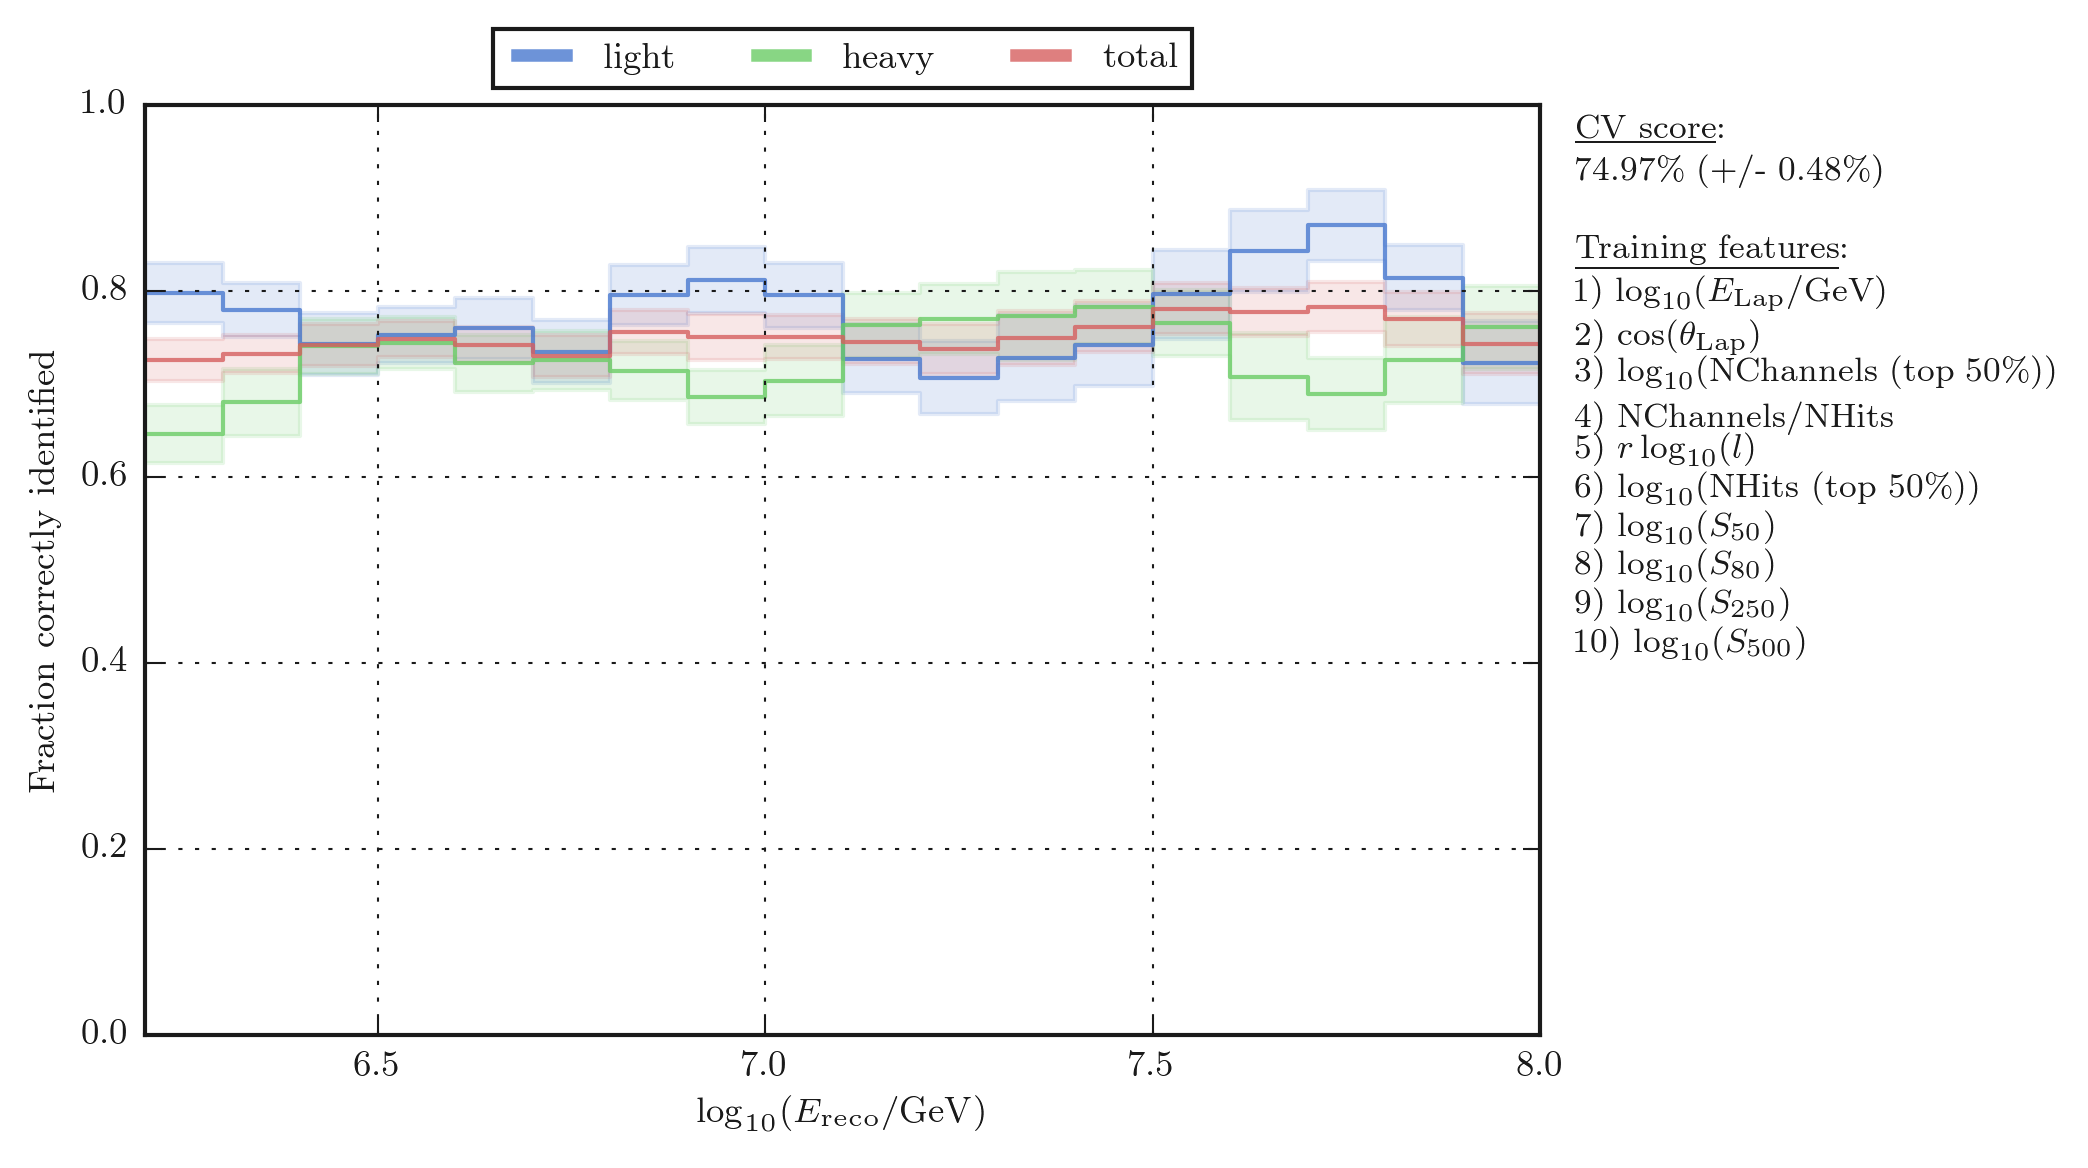

In [12]:
comp_list = ['light', 'heavy']
reco_frac, reco_frac_stat_err = get_frac_correct(X_train_sim, X_test_sim,
                                                 y_train_sim, y_test_sim,
                                                 comp_list)
# Energy-related variables
energy_bin_width = 0.1
energy_bins = np.arange(6.2, 8.1, energy_bin_width)
energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2
step_x = energy_midpoints
step_x = np.append(step_x[0]-energy_bin_width/2, step_x)
step_x = np.append(step_x, step_x[-1]+energy_bin_width/2)
# Plot fraction of events correctlt classified vs energy
fig, ax = plt.subplots()
for composition in comp_list + ['total']:
    err = np.sqrt(frac_correct_gen_err[composition]**2 + reco_frac_stat_err[composition]**2)
    plotting.plot_steps(energy_midpoints, reco_frac[composition], err, ax, color_dict[composition], composition)
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('Fraction correctly identified')
ax.set_ylim([0.0, 1.0])
ax.set_xlim([6.2, 8.0])
ax.grid()
leg = plt.legend(loc='upper center', 
          bbox_to_anchor=(0.5,  # horizontal
                          1.1),# vertical 
          ncol=len(comp_list)+1, fancybox=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

# place a text box in upper left in axes coords
textstr = '$\mathrm{\underline{Training \ features}}$: \n'
for i, label in enumerate(feature_labels):
    if (i == len(feature_labels)-1):
        textstr += '{}) '.format(i+1) + label
    else:
        textstr += '{}) '.format(i+1) + label + '\n'
props = dict(facecolor='white', linewidth=0)
ax.text(1.025, 0.855, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
cvstr = '$\mathrm{\underline{CV \ score}}$:\n' + '{:0.2f}\% (+/- {:.2}\%)'.format(scores.mean()*100, scores.std()*100)
print(cvstr)
props = dict(facecolor='white', linewidth=0)
ax.text(1.025, 0.9825, cvstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
plt.show()

## Spectrum

In [13]:
def get_num_comp_reco(X_train, y_train, X_test, comp_list):
    
    energy_train = X_train[:, 0]
    energy_test = X_test[:, 0]
    X_train = X_train[:, 1:]
    X_test = X_test[:, 1:]
    
    pipeline = comp.get_pipeline('RF')
    pipeline.fit(X_train, y_train)
    test_predictions = pipeline.predict(X_test)

    # Energy-related variables
    energy_bin_width = 0.1
    energy_bins = np.arange(6.2, 8.1, energy_bin_width)
    energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2
    log_energy = energy_test

    # Get number of correctly identified comp in each reco energy bin
    num_reco_energy, num_reco_energy_err = {}, {}
    for composition in comp_list:
        num_reco_energy[composition] = np.histogram(
            log_energy[le.inverse_transform(test_predictions) == composition],
            bins=energy_bins)[0]
        num_reco_energy_err[composition] = np.sqrt(num_reco_energy[composition])

    num_reco_energy['total'] = np.histogram(log_energy, bins=energy_bins)[0]
    num_reco_energy_err['total'] = np.sqrt(num_reco_energy['total'])
    
    return num_reco_energy, num_reco_energy_err

In [14]:
eff_area, eff_area_error, energy_midpoints = comp.analysis.get_effective_area(df_sim)

Calculating effective area...
Simulation set 7006: 30000 files
Simulation set 7007: 30000 files
Simulation set 7241: 10000 files
Simulation set 7242: 10000 files
Simulation set 7262: 19999 files
Simulation set 7263: 19998 files
Simulation set 7579: 12000 files
Simulation set 7784: 12000 files
Simulation set 7791: 12000 files
Simulation set 7851: 12000 files


0.942477796077
1.46998611753
570501.226571
[ 1.07974901  1.06469828  1.05113133  1.04174853  1.02945394  1.02679043
  1.02104471  1.00483983  1.00474499  1.01111382  1.00867478  1.00422289
  1.00252456  1.00199809  1.00408328  1.00430569  1.00404049  1.00493518]
[ 1.07974901  1.06469828  1.05113133  1.04174853  1.02945394  1.02679043
  1.02104471  1.00483983  1.00474499  1.01111382  1.00867478  1.00422289
  1.00252456  1.00199809  1.00408328  1.00430569  1.00404049  1.00493518]
[ 1.07974901  1.06469828  1.05113133  1.04174853  1.02945394  1.02679043
  1.02104471  1.00483983  1.00474499  1.01111382  1.00867478  1.00422289
  1.00252456  1.00199809  1.00408328  1.00430569  1.00404049  1.00493518]


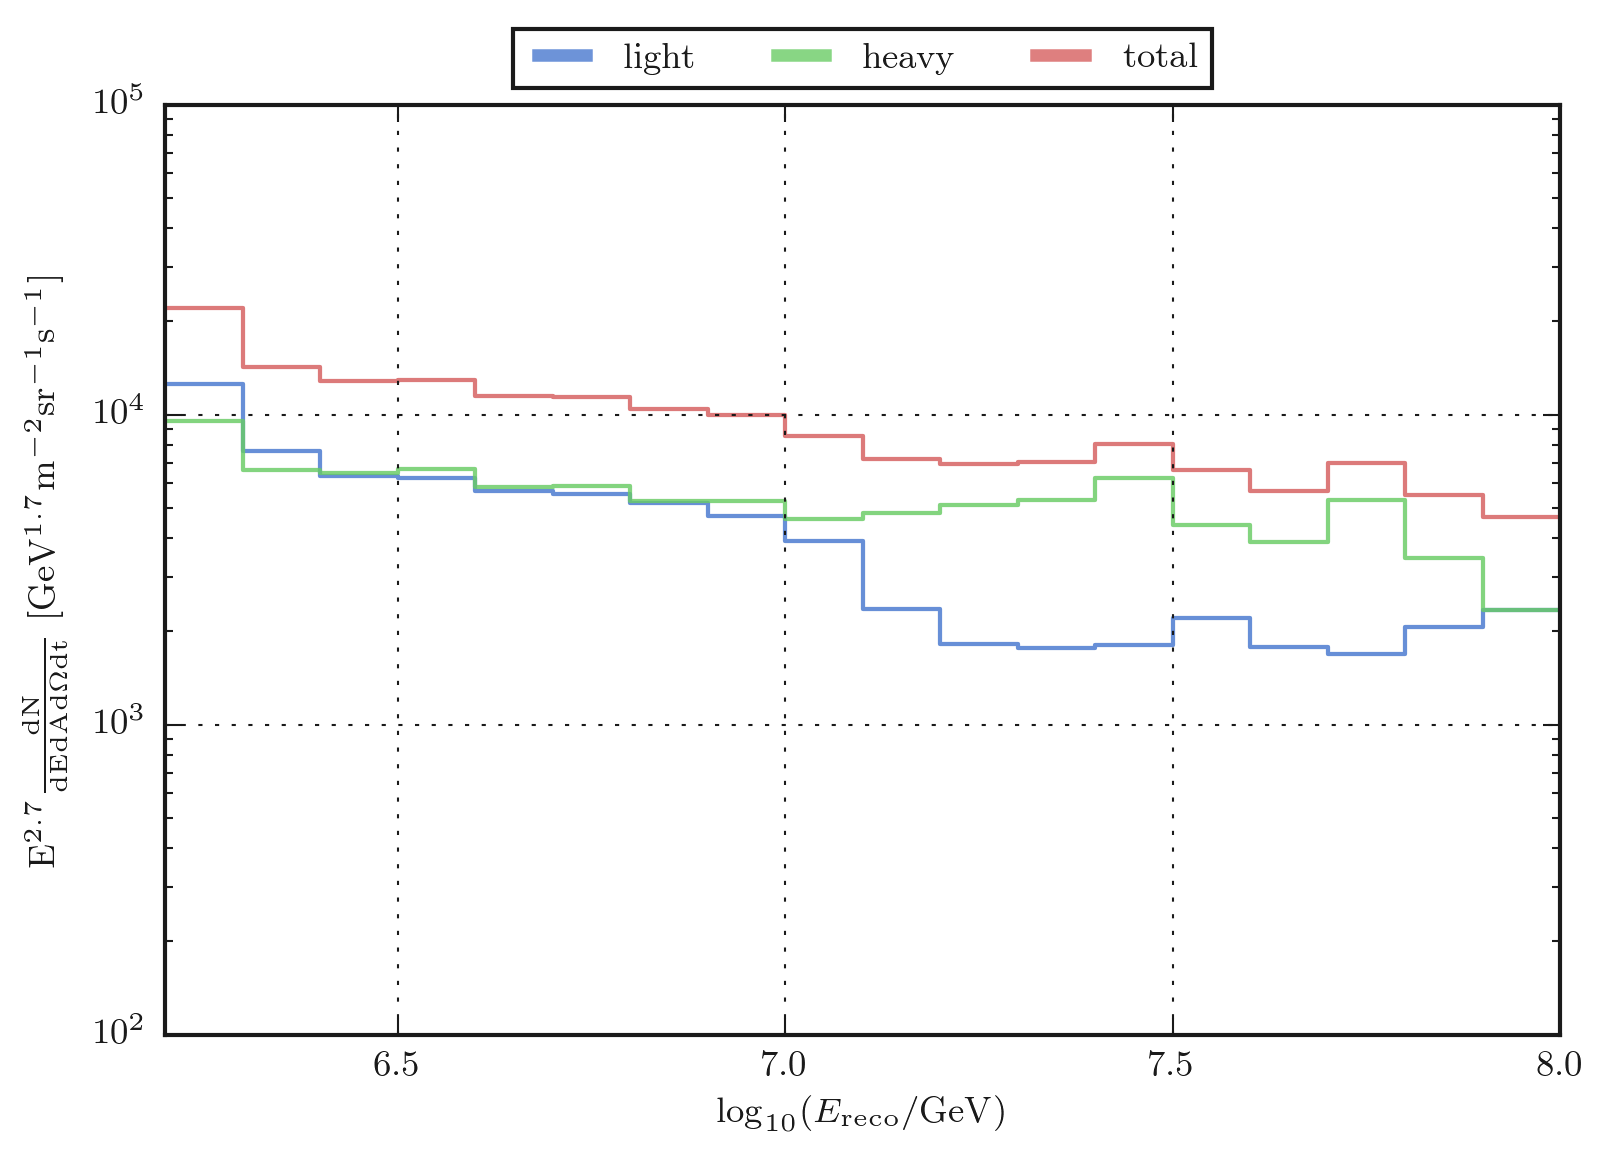

In [15]:
comp_list = ['light', 'heavy']
# Get number of events per energy bin
num_reco_energy, num_reco_energy_err = get_num_comp_reco(X_train_sim, y_train_sim, X_test_data, comp_list)
# Energy-related variables
energy_bin_width = 0.1
energy_bins = np.arange(6.2, 8.1, energy_bin_width)
energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2
energy_bin_widths = 10**energy_bins[1:] - 10**energy_bins[:-1]
def get_energy_res(df_sim, energy_bins):
    reco_log_energy = df_sim['lap_log_energy'].values 
    MC_log_energy = df_sim['MC_log_energy'].values
    energy_res = reco_log_energy - MC_log_energy
    bin_centers, bin_medians, energy_err = comp.analysis.data_functions.get_medians(reco_log_energy,
                                                                               energy_res,
                                                                               energy_bins)
    return np.abs(bin_medians)
# Solid angle
solid_angle = 2*np.pi*(1-np.cos(np.arccos(0.85)))
# solid_angle = 2*np.pi*(1-np.cos(40*(np.pi/180)))
print(solid_angle)
print(2*np.pi*(1-np.cos(40*(np.pi/180))))
# Live-time information
start_time = np.amin(df_data['start_time_mjd'].values)
end_time = np.amax(df_data['end_time_mjd'].values)
day_to_sec = 24 * 60 * 60.
dt = day_to_sec * (end_time - start_time)
print(dt)
# Plot fraction of events vs energy
fig, ax = plt.subplots()
for composition in comp_list + ['total']:
    # Calculate dN/dE
    y = num_reco_energy[composition]/energy_bin_widths
    y_err = num_reco_energy_err[composition]/energy_bin_widths
    # Add effective area
    y, y_err = comp.analysis.ratio_error(y, y_err, eff_area, eff_area_error)
    # Add solid angle
    y = y / solid_angle
    y_err = y_err / solid_angle
    # Add time duration
    y = y / dt
    y_err = y / dt
    # Add energy scaling 
    energy_err = get_energy_res(df_sim, energy_bins)
    energy_err = np.array(energy_err)
    print(10**energy_err)
    y = (10**energy_midpoints)**2.7 * y
    y_err = (10**energy_midpoints)**2.7 * y_err
    plotting.plot_steps(energy_midpoints, y, y_err, ax, color_dict[composition], composition)
ax.set_yscale("log", nonposy='clip')
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('$\mathrm{E}^{2.7} \\frac{\mathrm{dN}}{\mathrm{dE dA d\Omega dt}} \ [\mathrm{GeV}^{1.7} \mathrm{m}^{-2} \mathrm{sr}^{-1} \mathrm{s}^{-1}]$')
ax.set_xlim([6.2, 8.0])
ax.set_ylim([10**2, 10**5])
ax.grid()
leg = plt.legend(loc='upper center', 
          bbox_to_anchor=(0.5,  # horizontal
                          1.1),# vertical 
          ncol=len(comp_list)+1, fancybox=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)
    
plt.show()

## Unfolding

Normalized confusion matrix
[[ 0.76445  0.23555]
 [ 0.27952  0.72048]]


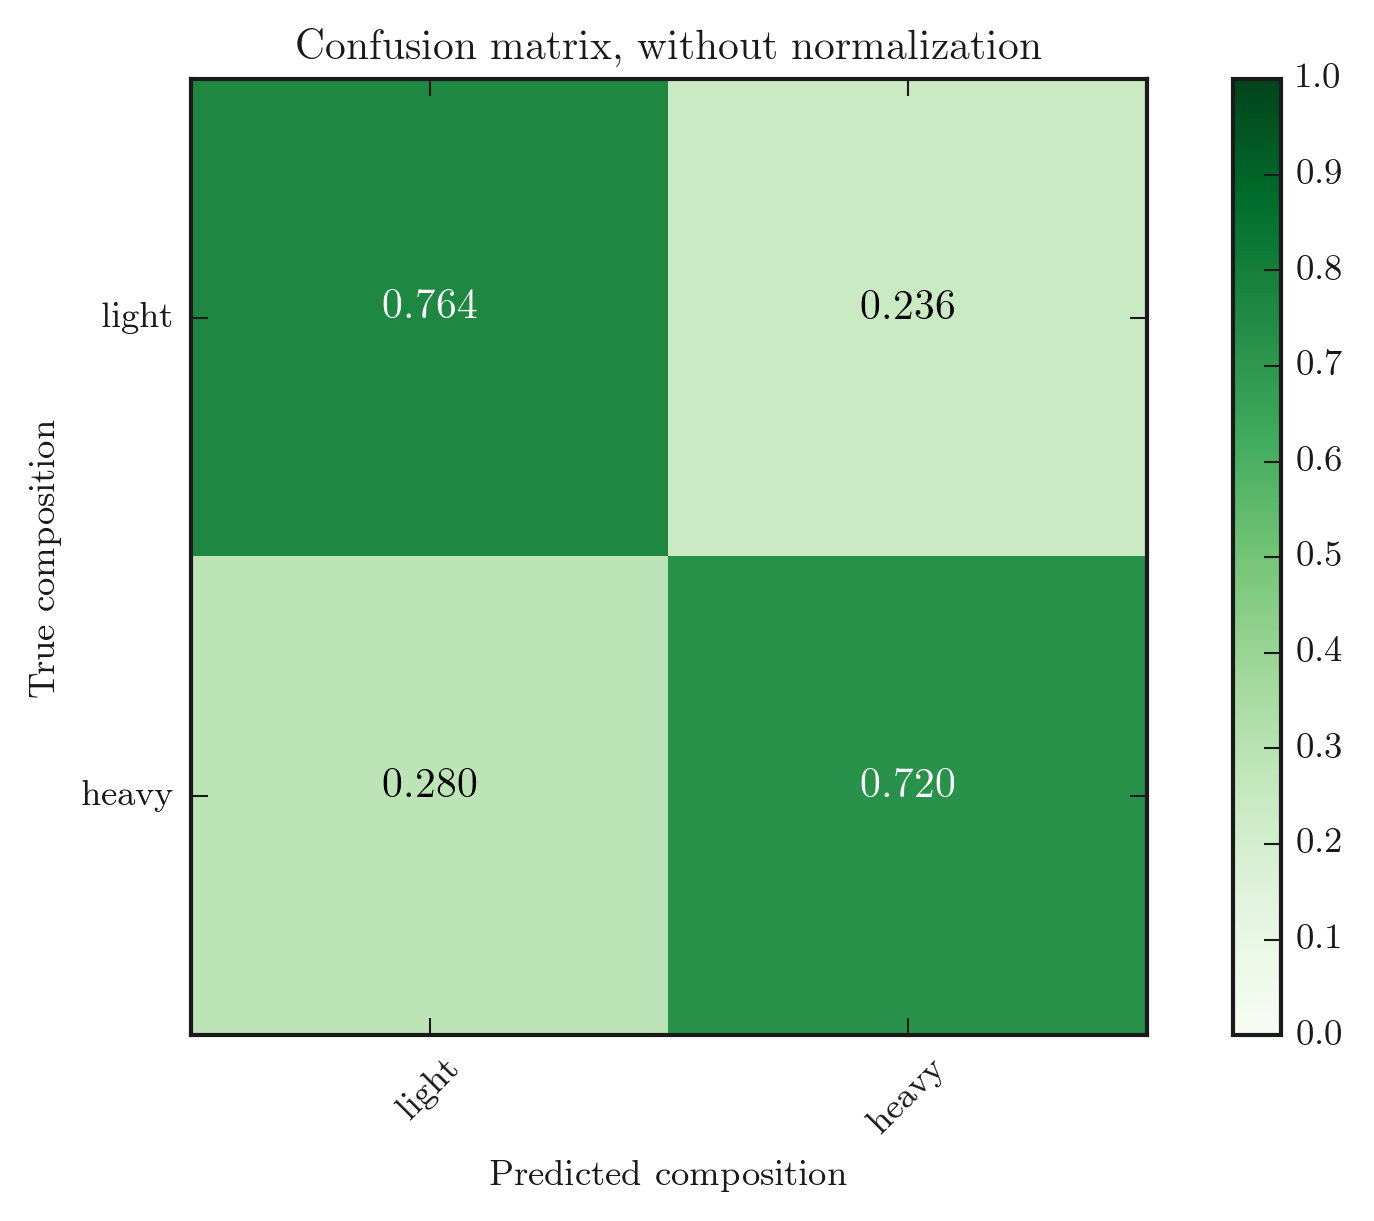

In [43]:
comp_list = ['light', 'heavy']
pipeline = comp.get_pipeline('RF')
pipeline.fit(X_train_sim, y_train_sim)
test_predictions = pipeline.predict(X_test_sim)
# correctly_identified_mask = (test_predictions == y_test)
# confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)/len(y_pred)
true_comp = le.inverse_transform(y_test_sim)
pred_comp = le.inverse_transform(test_predictions)
confmat = confusion_matrix(true_comp, pred_comp, labels=comp_list)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='None', cmap=cmap,
               vmin=0, vmax=1.0)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:0.3f}'.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True composition')
    plt.xlabel('Predicted composition')

fig, ax = plt.subplots()
plot_confusion_matrix(confmat, classes=['light', 'heavy'], normalize=True,
                      title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()

In [63]:
comp_list = ['light', 'heavy']
pipeline = comp.get_pipeline('RF')
pipeline.fit(X_train_sim, y_train_sim)
test_predictions = pipeline.predict(X_test_sim)
# correctly_identified_mask = (test_predictions == y_test)
# confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)/len(y_pred)
true_comp = le.inverse_transform(y_test_sim)
pred_comp = le.inverse_transform(test_predictions)
confmat = confusion_matrix(true_comp, pred_comp, labels=comp_list)

inverse = np.linalg.inv(confmat)
inverse

array([[  4.65885e-05,  -1.58473e-05],
       [ -1.80751e-05,   5.14300e-05]])

In [64]:
confmat

array([[24379,  7512],
       [ 8568, 22084]])

0.942477796077
1.46998611753
1409662.44128
[[  1.09286e+00   4.25348e-01]
 [  6.78230e-01   4.21116e-01]
 [  3.64535e-01   4.12274e-01]
 [  2.15254e-01   3.05955e-01]
 [  1.50773e-01   1.80818e-01]
 [  9.30369e-02   1.16594e-01]
 [  6.14838e-02   6.87016e-02]
 [  2.92043e-02   5.37845e-02]
 [  1.02666e-02   4.00306e-02]
 [  2.43373e-03   2.84436e-02]
 [  4.68133e-03   1.48927e-02]
 [  1.87090e-03   1.15002e-02]
 [ -6.73351e-04   9.90623e-03]
 [ -2.40343e-04   5.57233e-03]
 [ -2.92290e-04   4.14347e-03]
 [ -1.09387e-04   2.35180e-03]
 [ -2.28537e-04   1.67352e-03]
 [ -9.98517e-05   9.89654e-04]]
[[  1.09286e+00   4.25348e-01]
 [  6.78230e-01   4.21116e-01]
 [  3.64535e-01   4.12274e-01]
 [  2.15254e-01   3.05955e-01]
 [  1.50773e-01   1.80818e-01]
 [  9.30369e-02   1.16594e-01]
 [  6.14838e-02   6.87016e-02]
 [  2.92043e-02   5.37845e-02]
 [  1.02666e-02   4.00306e-02]
 [  2.43373e-03   2.84436e-02]
 [  4.68133e-03   1.48927e-02]
 [  1.87090e-03   1.15002e-02]
 [ -6.73351e-04   9.90623e

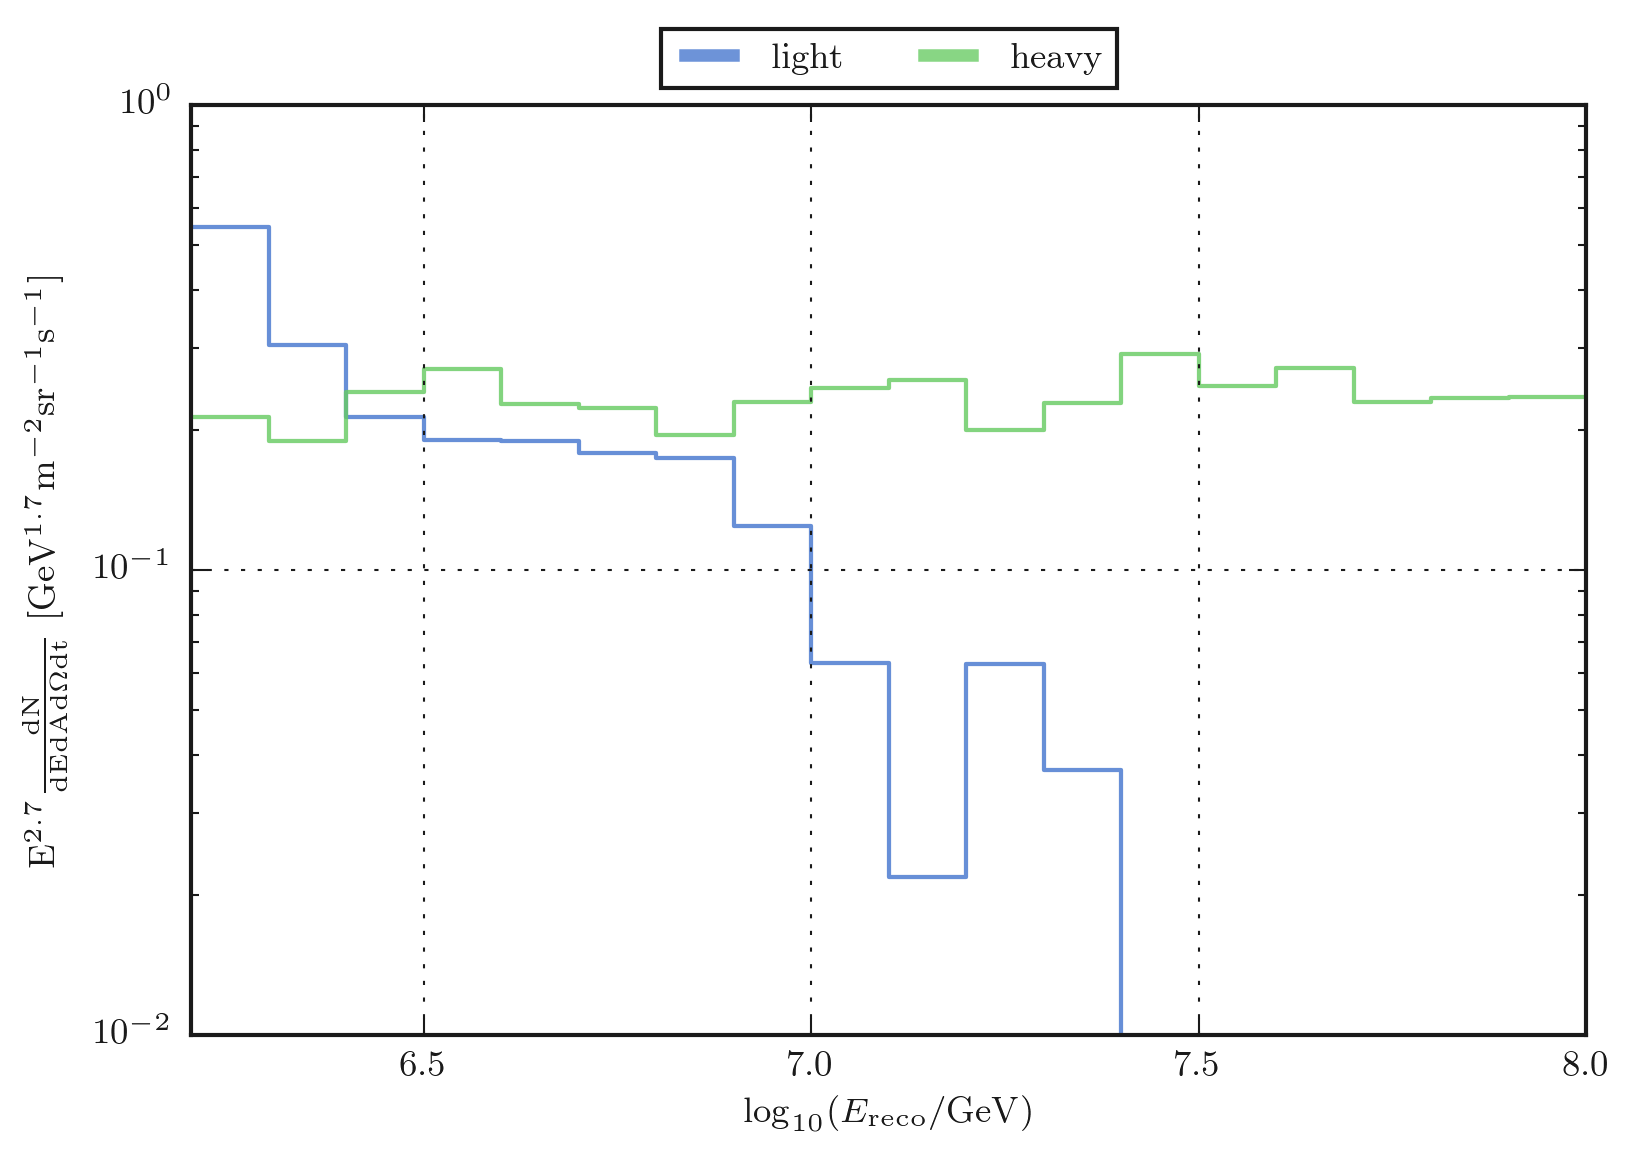

In [66]:
comp_list = ['light', 'heavy']
# Get number of events per energy bin
num_reco_energy, num_reco_energy_err = get_num_comp_reco(X_train_sim, y_train_sim, X_test_data, comp_list)
# Energy-related variables
energy_bin_width = 0.1
energy_bins = np.arange(6.2, 8.1, energy_bin_width)
energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2
energy_bin_widths = 10**energy_bins[1:] - 10**energy_bins[:-1]
def get_energy_res(df_sim, energy_bins):
    reco_log_energy = df_sim['lap_log_energy'].values 
    MC_log_energy = df_sim['MC_log_energy'].values
    energy_res = reco_log_energy - MC_log_energy
    bin_centers, bin_medians, energy_err = comp.analysis.data_functions.get_medians(reco_log_energy,
                                                                               energy_res,
                                                                               energy_bins)
    return np.abs(bin_medians)
# Solid angle
solid_angle = 2*np.pi*(1-np.cos(np.arccos(0.85)))
# solid_angle = 2*np.pi*(1-np.cos(40*(np.pi/180)))
print(solid_angle)
print(2*np.pi*(1-np.cos(40*(np.pi/180))))
# Live-time information
start_time = np.amin(df_data['start_time_mjd'].values)
end_time = np.amax(df_data['end_time_mjd'].values)
day_to_sec = 24 * 60 * 60.
dt = day_to_sec * (end_time - start_time)
print(dt)
# Plot fraction of events vs energy
fig, ax = plt.subplots()
for i, composition in enumerate(comp_list):
    num_reco_bin = np.array([[i, j] for i, j in zip(num_reco_energy['light'], num_reco_energy['heavy'])])
#     print(num_reco_bin)
    num_reco = np.array([np.dot(inverse, i) for i in num_reco_bin])
    print(num_reco)
    num_reco_2 = {'light': num_reco[:, 0], 'heavy': num_reco[:, 1]}
    # Calculate dN/dE
    y = num_reco_2[composition]/energy_bin_widths
    y_err = num_reco_energy_err[composition]/energy_bin_widths
    # Add effective area
    y, y_err = comp.analysis.ratio_error(y, y_err, eff_area, eff_area_error)
    # Add solid angle
    y = y / solid_angle
    y_err = y_err / solid_angle
    # Add time duration
    y = y / dt
    y_err = y / dt
    # Add energy scaling 
    energy_err = get_energy_res(df_sim, energy_bins)
    energy_err = np.array(energy_err)
#     print(10**energy_err)
    y = (10**energy_midpoints)**2.7 * y
    y_err = (10**energy_midpoints)**2.7 * y_err
    plotting.plot_steps(energy_midpoints, y, y_err, ax, color_dict[composition], composition)
ax.set_yscale("log", nonposy='clip')
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('$\mathrm{E}^{2.7} \\frac{\mathrm{dN}}{\mathrm{dE dA d\Omega dt}} \ [\mathrm{GeV}^{1.7} \mathrm{m}^{-2} \mathrm{sr}^{-1} \mathrm{s}^{-1}]$')
ax.set_xlim([6.2, 8.0])
# ax.set_ylim([10**2, 10**5])
ax.grid()
leg = plt.legend(loc='upper center', 
          bbox_to_anchor=(0.5,  # horizontal
                          1.1),# vertical 
          ncol=len(comp_list)+1, fancybox=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)
    
plt.show()

In [44]:
pipeline.get_params()['classifier__max_depth']

6

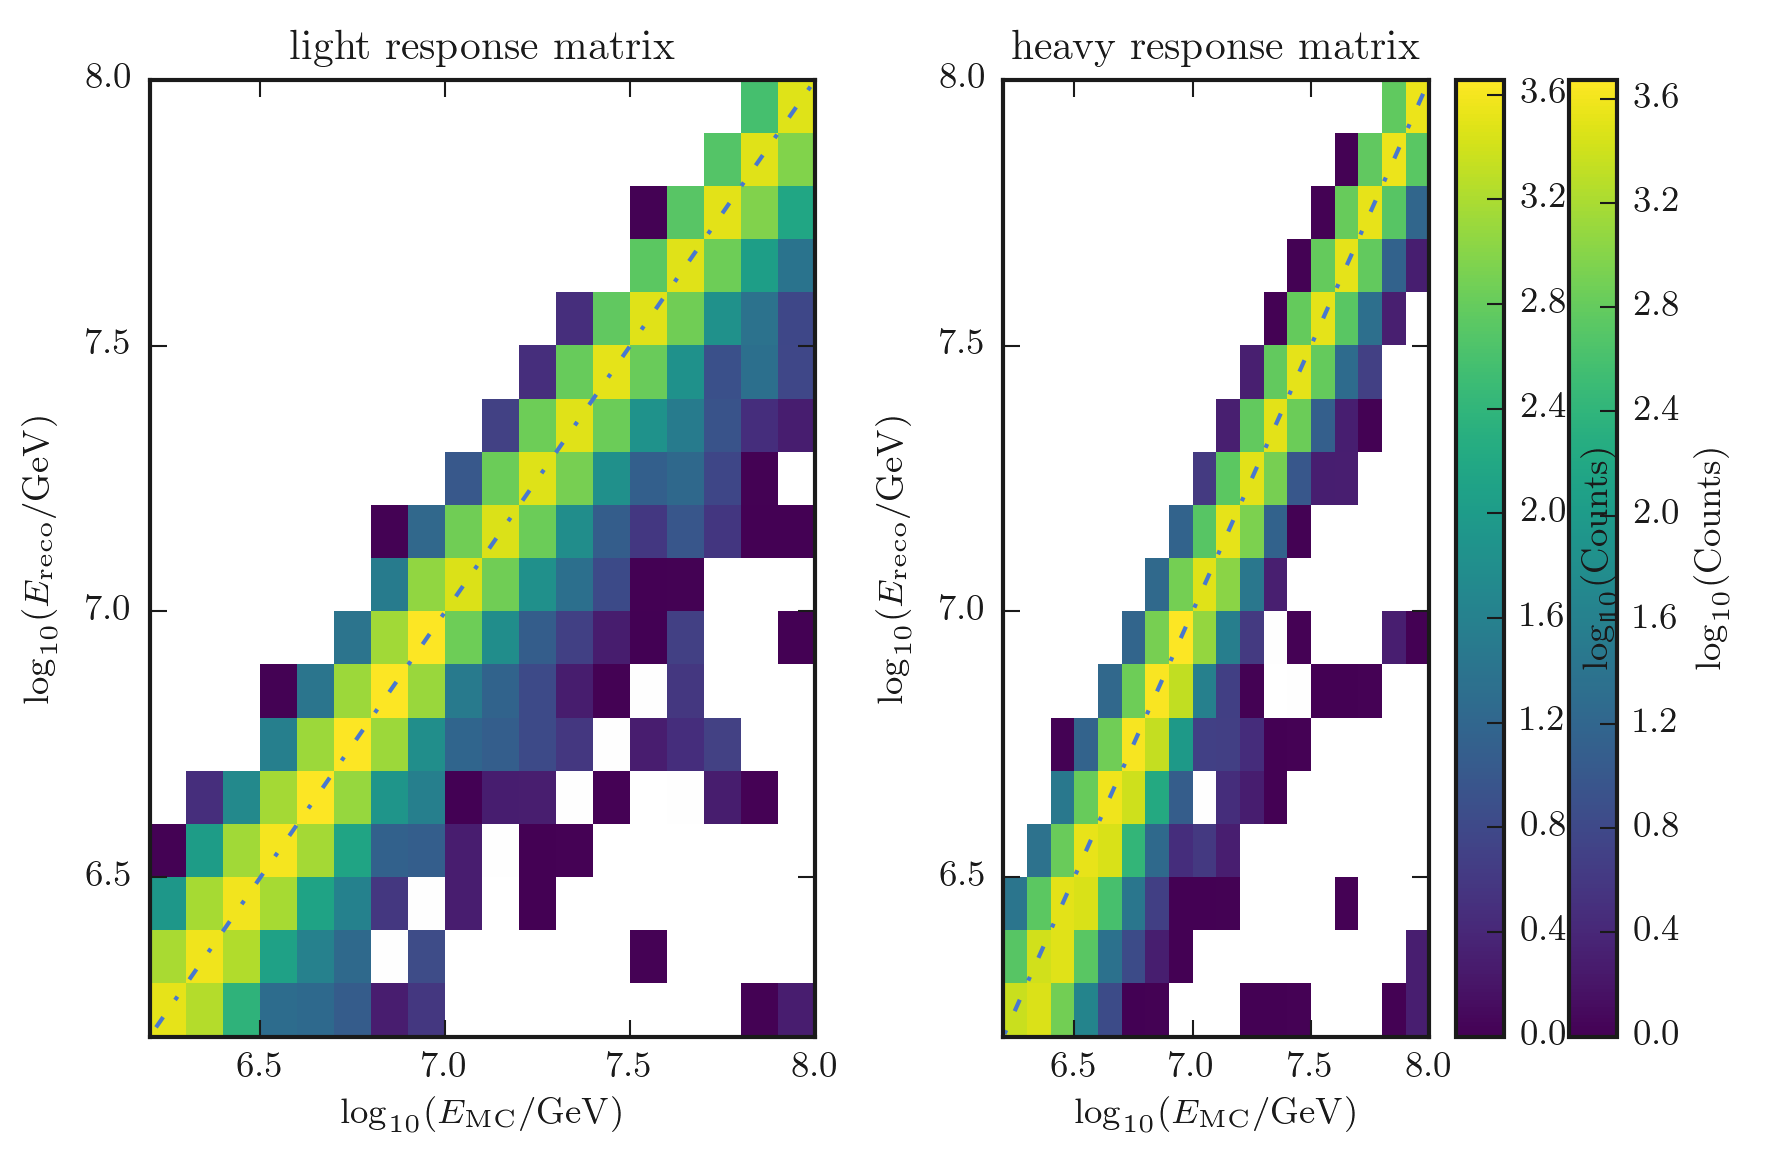

In [47]:
energy_bin_width = 0.1
energy_bins = np.arange(6.2, 8.1, energy_bin_width)
fig, axarr = plt.subplots(1, 2)
for composition, ax in zip(comp_list, axarr.flatten()):
    MC_comp_mask = (df_sim['MC_comp_class'] == composition)
    MC_log_energy = df_sim['MC_log_energy'][MC_comp_mask].values
    reco_log_energy = df_sim['lap_log_energy'][MC_comp_mask].values
    plotting.histogram_2D(MC_log_energy, reco_log_energy, energy_bins, log_counts=True, ax=ax)
    ax.plot([0,10], [0,10], marker='None', linestyle='-.')
    ax.set_xlim([6.2, 8])
    ax.set_ylim([6.2, 8])
    ax.set_xlabel('$\log_{10}(E_{\mathrm{MC}}/\mathrm{GeV})$')
    ax.set_ylabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
    ax.set_title('{} response matrix'.format(composition))
plt.tight_layout()
plt.show()

In [10]:
energy_bins = np.arange(6.2, 8.1, energy_bin_width)
10**energy_bins[1:] - 10**energy_bins[:-1]

array([   410369.12250776,    516624.1165407 ,    650391.2286588 ,
          818794.04536659,   1030800.63073774,   1297701.1085292 ,
         1633708.90244087,   2056717.65275717,   2589254.11794165,
         3259677.80666943,   4103691.22507761,   5166241.16540694,
         6503912.28658791,   8187940.45366581,  10308006.30737735,
        12977011.08529189,  16337089.02440856,  20567176.52757148])

In [ ]:
probs = pipeline.named_steps['classifier'].predict_proba(X_test)
prob_1 = probs[:, 0][MC_iron_mask]
prob_2 = probs[:, 1][MC_iron_mask]
# print(min(prob_1-prob_2))
# print(max(prob_1-prob_2))
# plt.hist(prob_1-prob_2, bins=30, log=True)
plt.hist(prob_1, bins=np.linspace(0, 1, 50), log=True)
plt.hist(prob_2, bins=np.linspace(0, 1, 50), log=True)

In [ ]:
probs = pipeline.named_steps['classifier'].predict_proba(X_test)
dp1 = (probs[:, 0]-probs[:, 1])[MC_proton_mask]
print(min(dp1))
print(max(dp1))
dp2 = (probs[:, 0]-probs[:, 1])[MC_iron_mask]
print(min(dp2))
print(max(dp2))
fig, ax = plt.subplots()
# plt.hist(prob_1-prob_2, bins=30, log=True)
counts, edges, pathes = plt.hist(dp1, bins=np.linspace(-1, 1, 100), log=True, label='Proton', alpha=0.75)
counts, edges, pathes = plt.hist(dp2, bins=np.linspace(-1, 1, 100), log=True, label='Iron', alpha=0.75)
plt.legend(loc=2)
plt.show()
pipeline.named_steps['classifier'].classes_

In [ ]:
print(pipeline.named_steps['classifier'].classes_)
le.inverse_transform(pipeline.named_steps['classifier'].classes_)

In [ ]:
pipeline.named_steps['classifier'].decision_path(X_test)

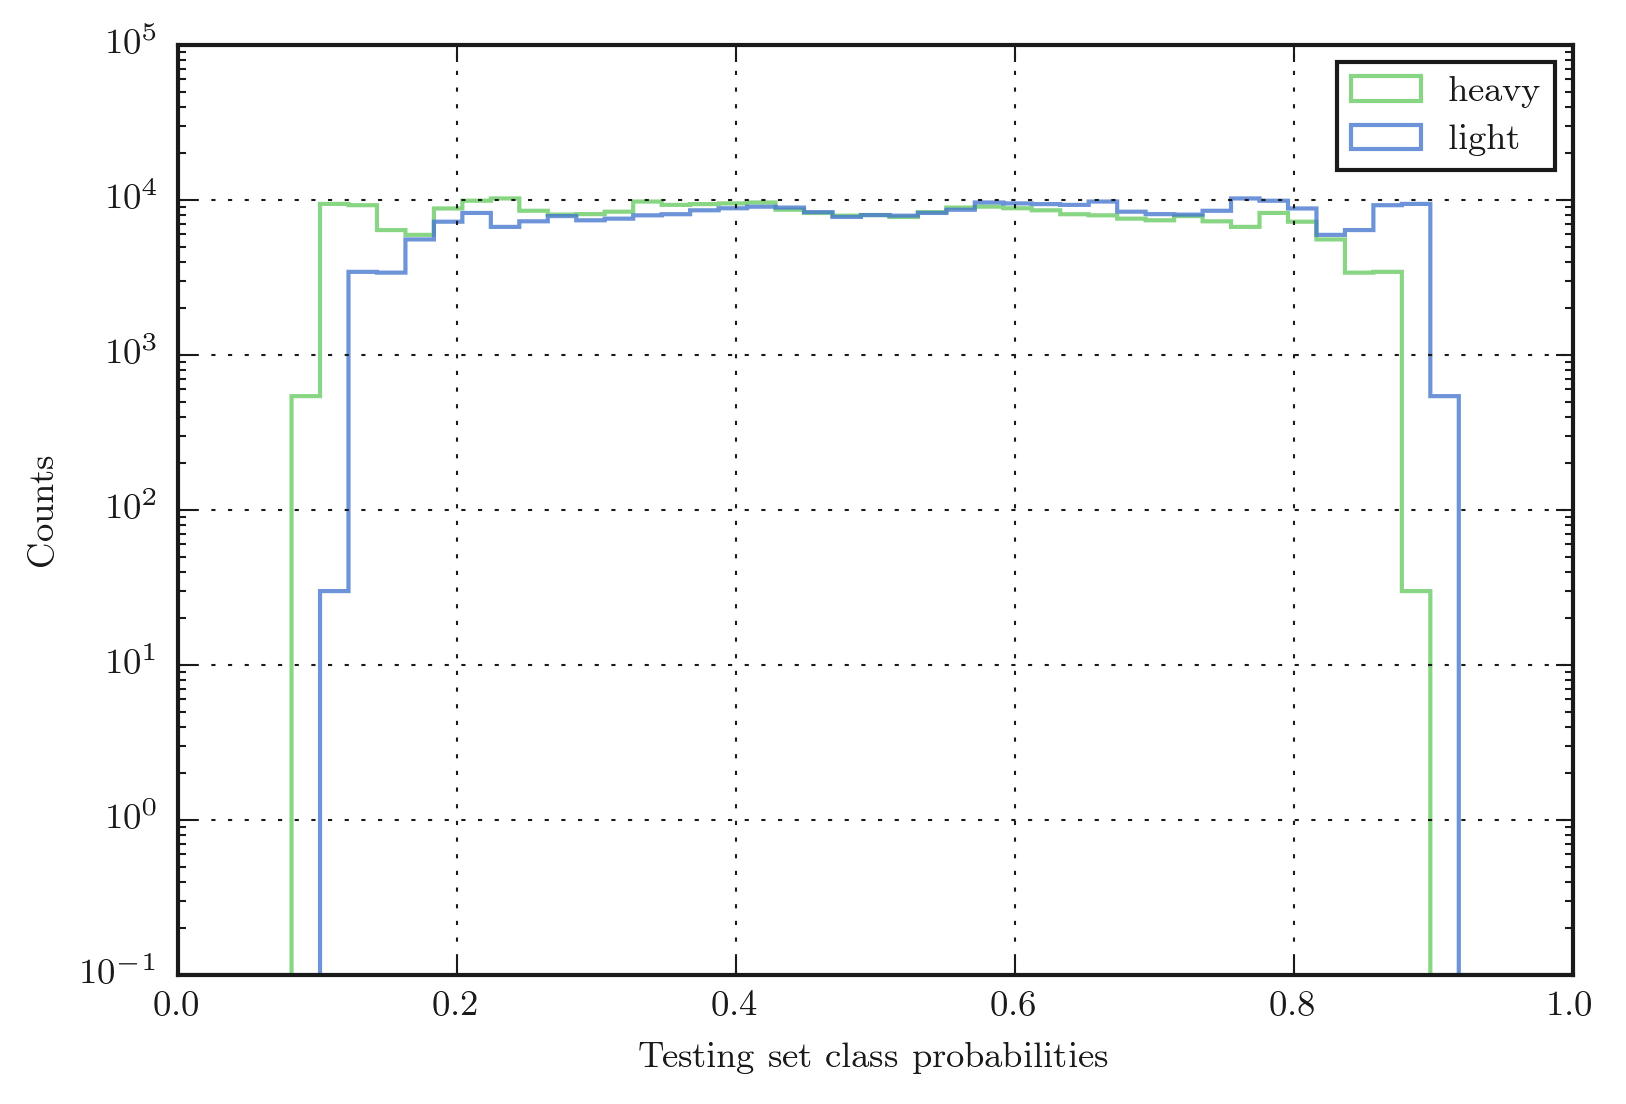

In [48]:
comp_list = ['light', 'heavy']
pipeline = comp.get_pipeline('RF')
pipeline.fit(X_train_sim, y_train_sim)
# test_probs = defaultdict(list)
fig, ax = plt.subplots()
test_predictions = pipeline.predict(X_test_data)
test_probs = pipeline.predict_proba(X_test_data)
for class_ in pipeline.classes_:
    test_predictions == le.inverse_transform(class_)
    plt.hist(test_probs[:, class_], bins=np.linspace(0, 1, 50),
             histtype='step', label=composition,
             color=color_dict[composition], alpha=0.8, log=True)
plt.ylabel('Counts')
plt.xlabel('Testing set class probabilities')
plt.legend()
plt.grid()
plt.show()

probs = (15883, 4)
min = 1.38011981318
max = 3.56902754108
probs = (15920, 4)
min = 1.40518894839
max = 3.5562126663
probs = (15507, 4)
min = 1.45593414673
max = 3.57278805564
probs = (15066, 4)
min = 1.50426220527
max = 3.60566706999


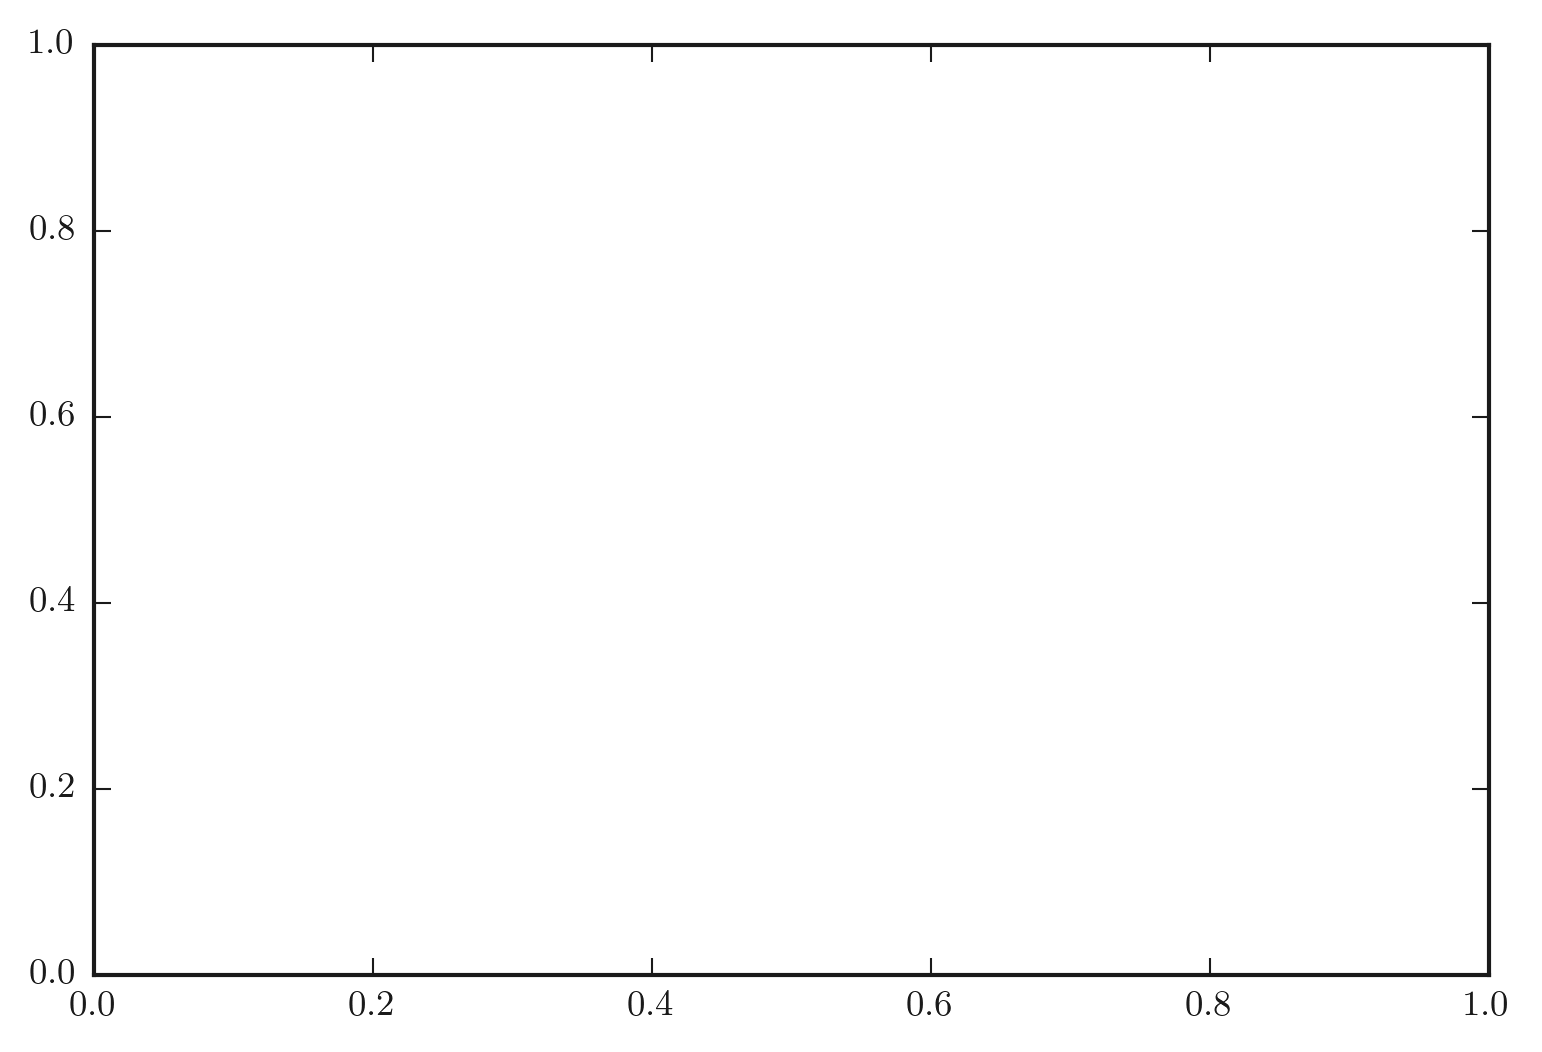

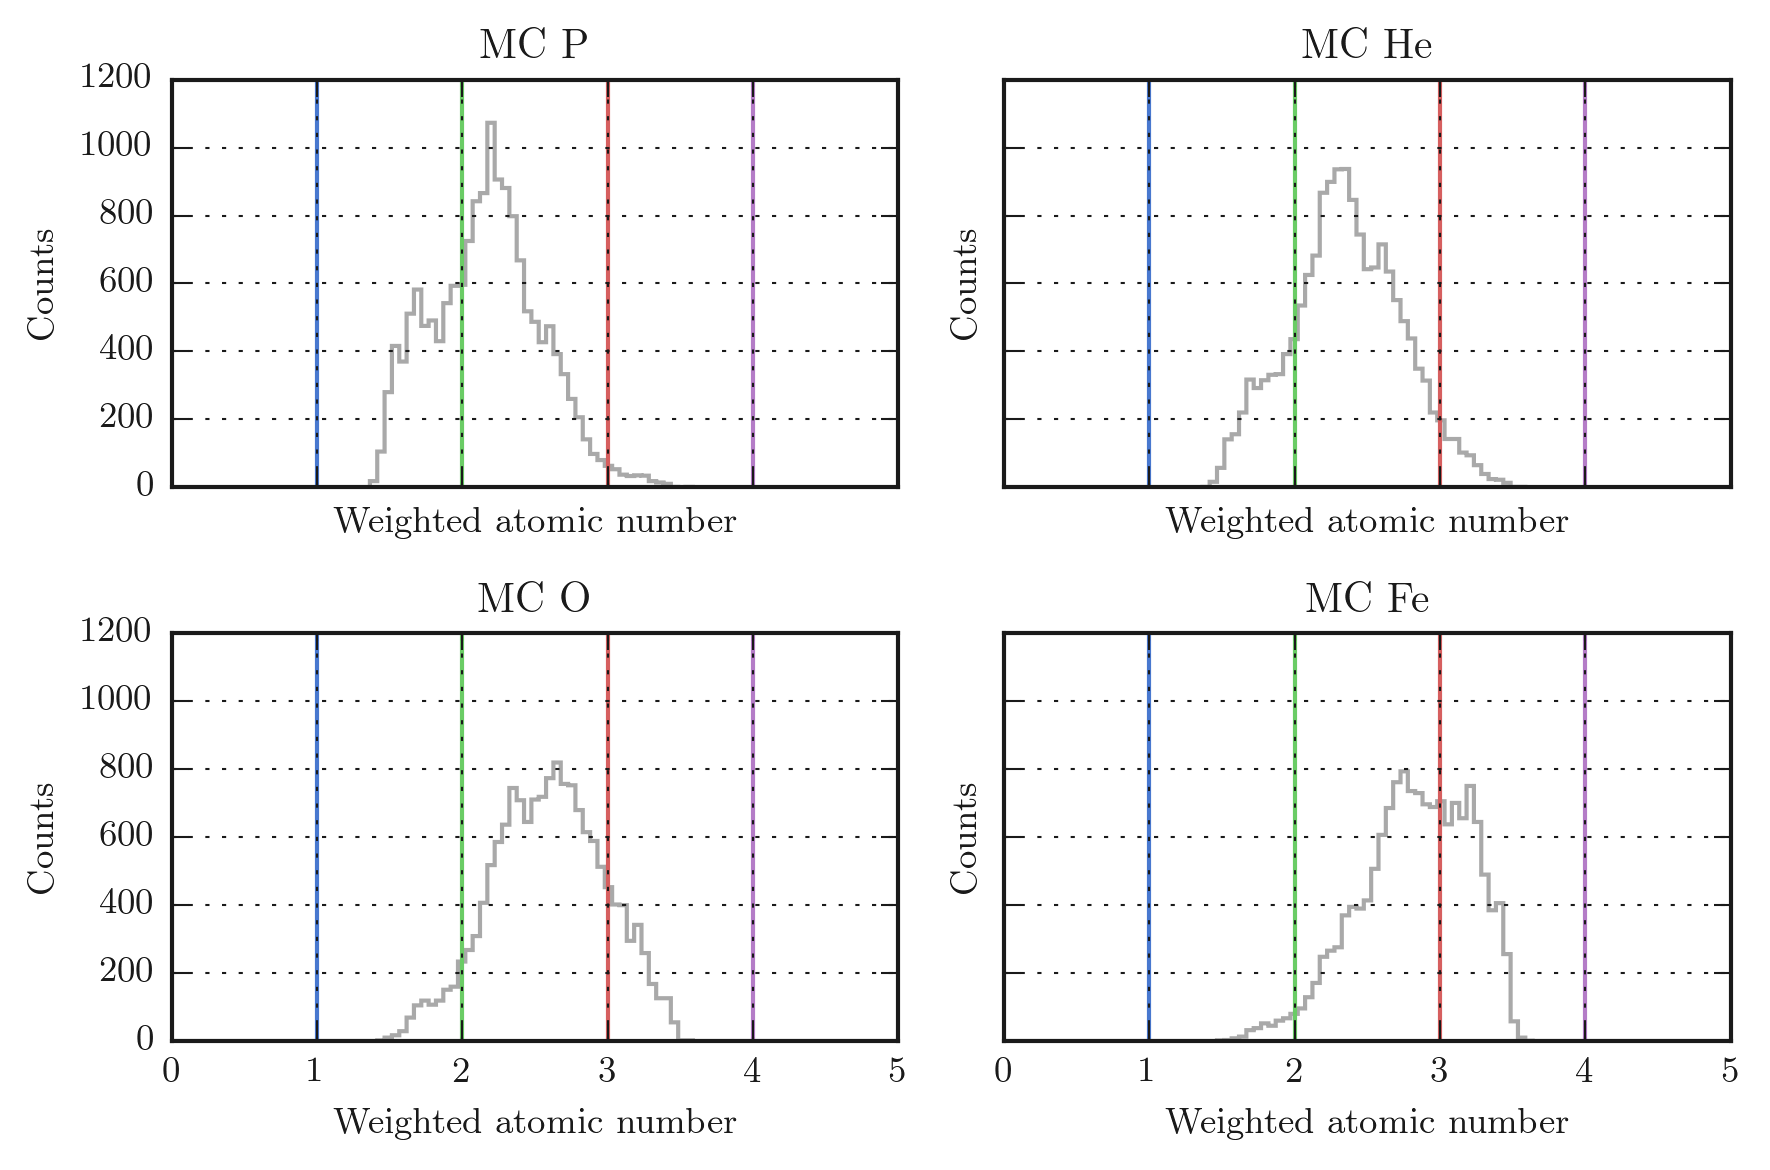

In [5]:
pipeline = comp.get_pipeline('RF')
pipeline.fit(X_train, y_train)
test_predictions = pipeline.predict(X_test)

comp_list = ['P', 'He', 'O', 'Fe']
fig, ax = plt.subplots()
test_probs = pipeline.predict_proba(X_test)
fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
for composition, ax in zip(comp_list, axarr.flatten()):
    comp_mask = (le.inverse_transform(y_test) == composition)
    probs = np.copy(test_probs[comp_mask])
    print('probs = {}'.format(probs.shape))
    weighted_mass = np.zeros(len(probs))
    for class_ in pipeline.classes_:
        c = le.inverse_transform(class_)
        weighted_mass += comp.simfunctions.comp2mass(c) * probs[:, class_]
    print('min = {}'.format(min(weighted_mass)))
    print('max = {}'.format(max(weighted_mass)))
    ax.hist(weighted_mass, bins=np.linspace(0, 5, 100),
             histtype='step', label=None, color='darkgray',
             alpha=1.0, log=False)
    for c in comp_list:
        ax.axvline(comp.simfunctions.comp2mass(c), color=color_dict[c],
                   marker='None', linestyle='-')
    ax.set_ylabel('Counts')
    ax.set_xlabel('Weighted atomic number')
    ax.set_title('MC {}'.format(composition))
    ax.grid()
plt.tight_layout()
plt.show()

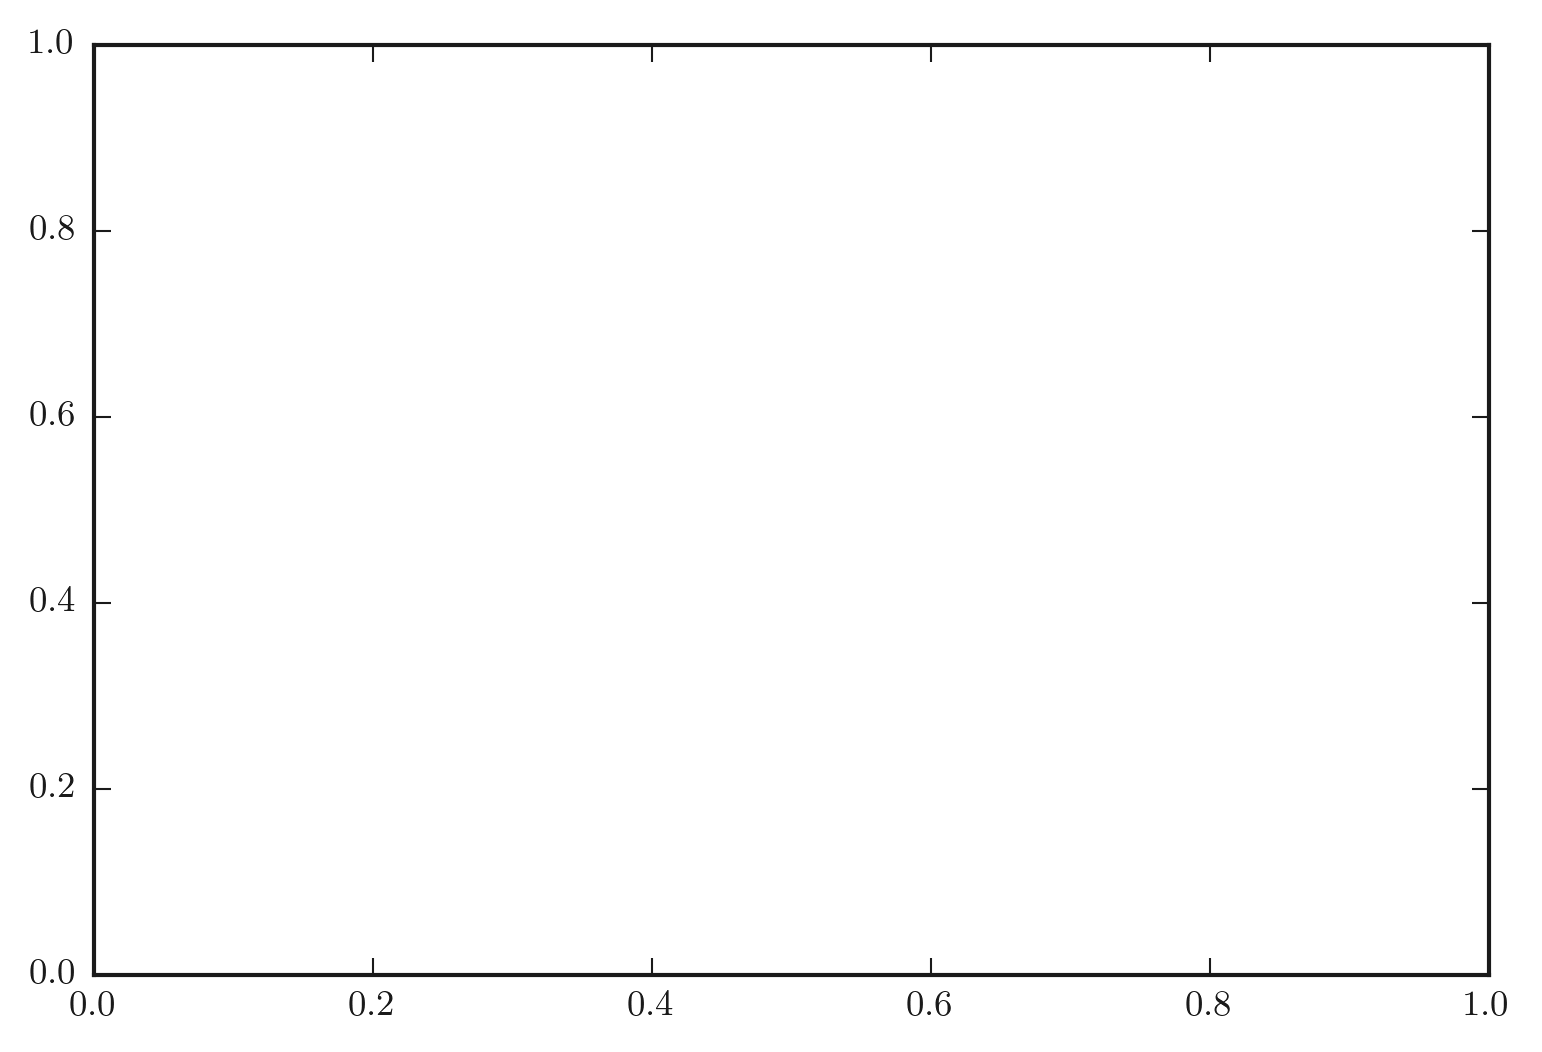

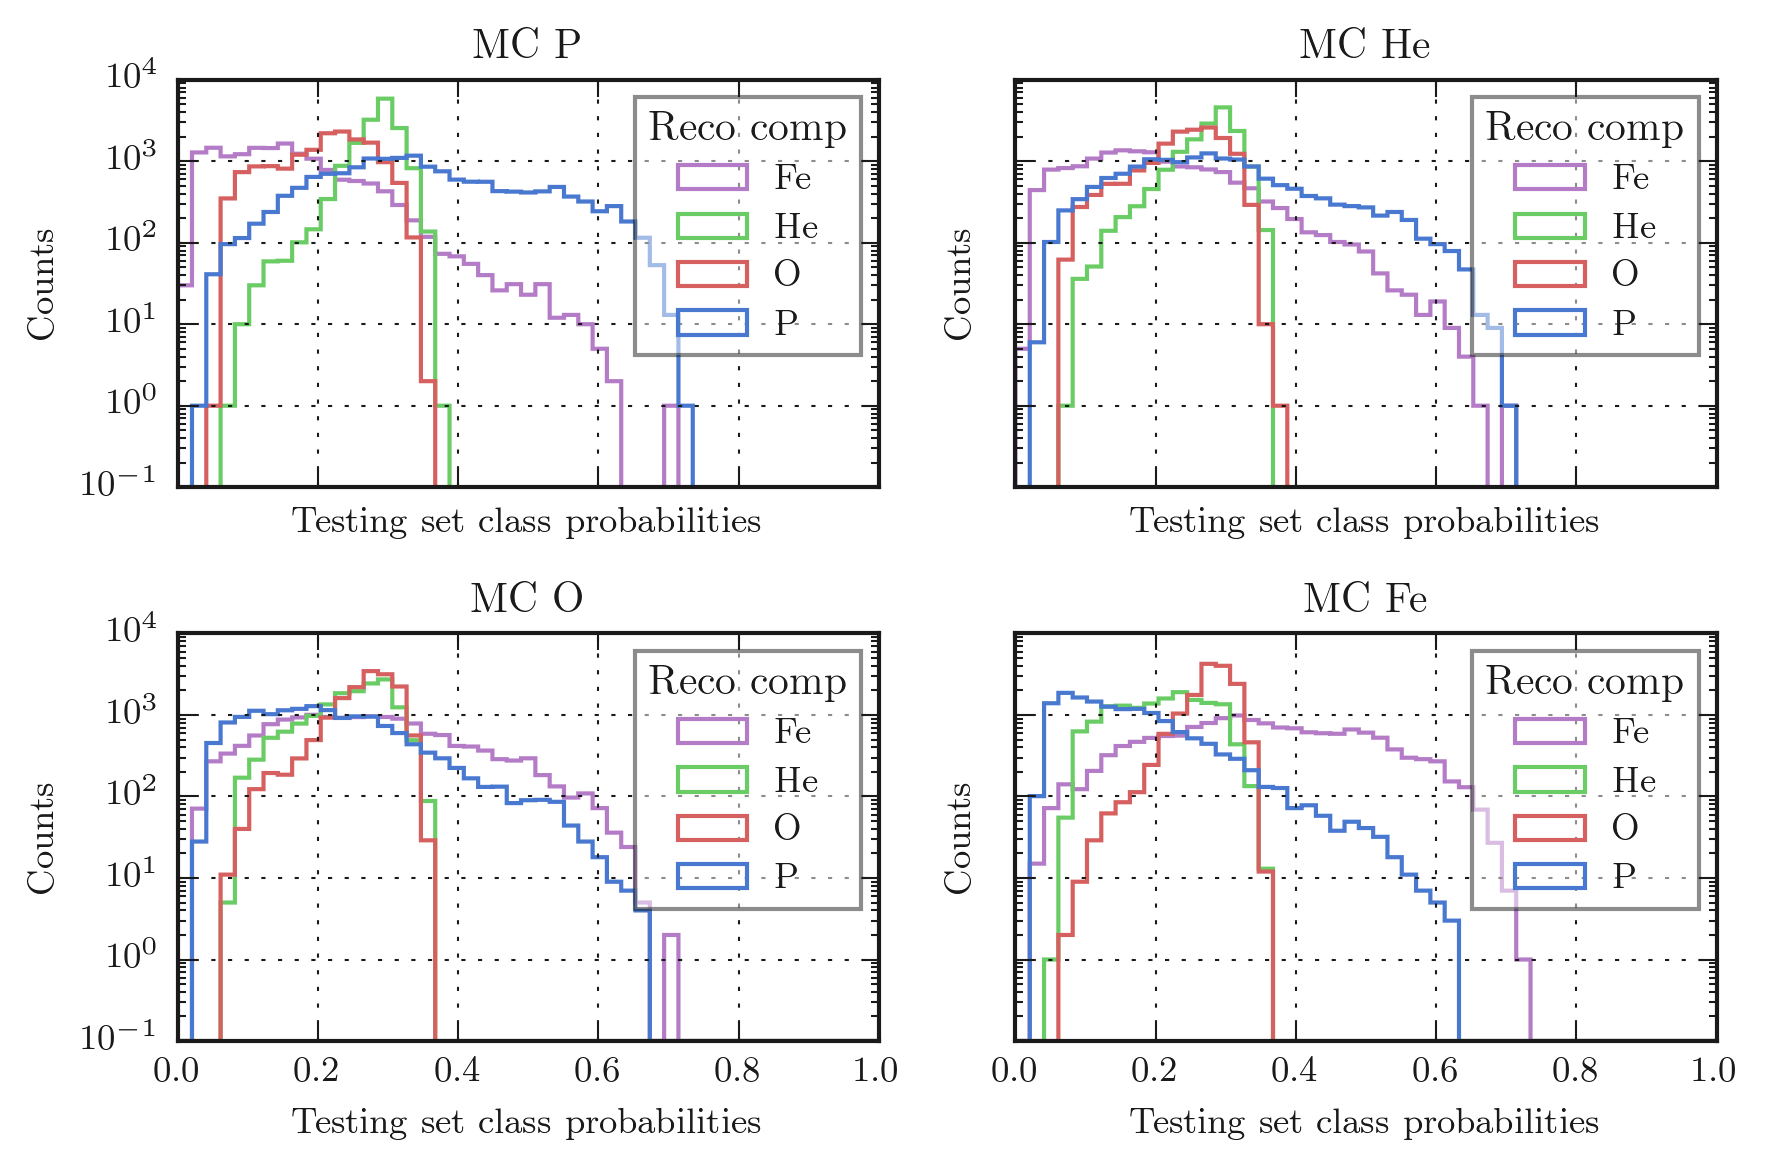

In [15]:
pipeline = comp.get_pipeline('RF')
pipeline.fit(X_train, y_train)
test_predictions = pipeline.predict(X_test)

comp_list = ['P', 'He', 'O', 'Fe']
fig, ax = plt.subplots()
test_probs = pipeline.predict_proba(X_test)
fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
for composition, ax in zip(comp_list, axarr.flatten()):
    comp_mask = (le.inverse_transform(y_test) == composition)
    probs = np.copy(test_probs[comp_mask])
    weighted_mass = np.zeros(len(probs))
    for class_ in pipeline.classes_:
        c = le.inverse_transform(class_)
        ax.hist(probs[:, class_], bins=np.linspace(0, 1, 50),
                 histtype='step', label=c, color=color_dict[c],
                 alpha=1.0, log=True)
    ax.legend(title='Reco comp', framealpha=0.5)
    ax.set_ylabel('Counts')
    ax.set_xlabel('Testing set class probabilities')
    ax.set_title('MC {}'.format(composition))
    ax.grid()
plt.tight_layout()
plt.show()

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

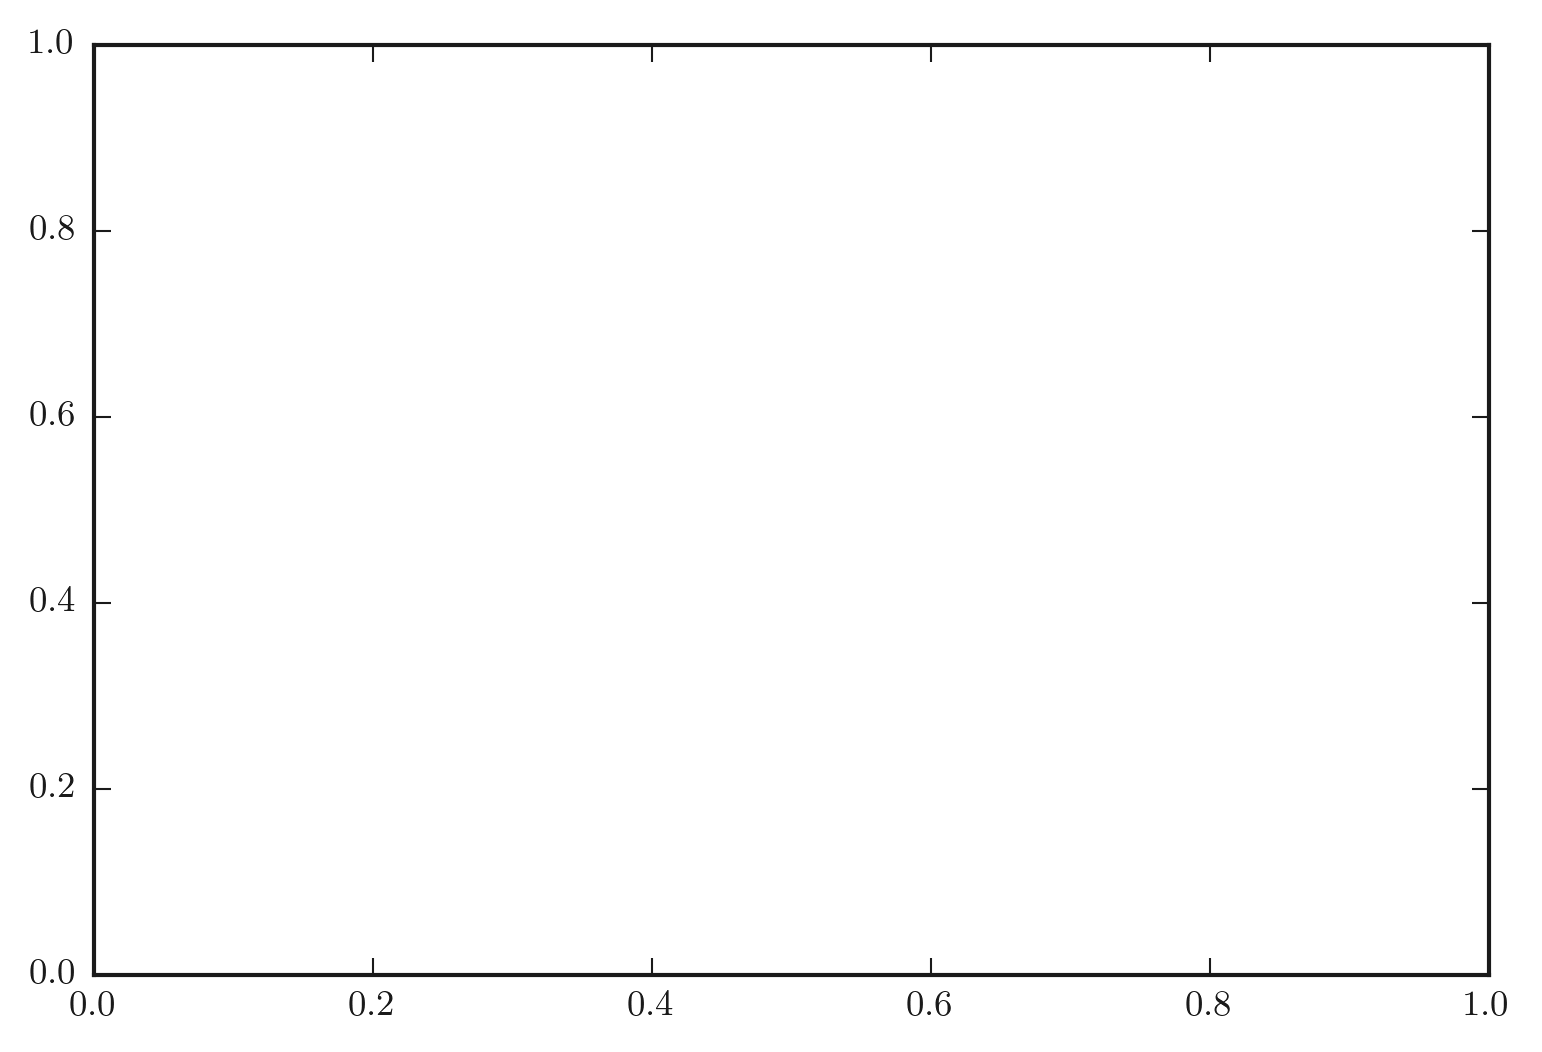

In [25]:
comp_list = ['light', 'heavy']
test_probs = defaultdict(list)
fig, ax = plt.subplots()
# test_probs = pipeline.predict_proba(X_test)
for event in pipeline.predict_proba(X_test_data):
    composition = le.inverse_transform(np.argmax(event))
    test_probs[composition].append(np.amax(event))
for composition in comp_list:
    plt.hist(test_probs[composition], bins=np.linspace(0, 1, 100),
             histtype='step', label=composition,
             color=color_dict[composition], alpha=0.8, log=False)
plt.ylabel('Counts')
plt.xlabel('Testing set class probabilities')
plt.legend(title='Reco comp')
plt.grid()
plt.show()